# Drizzle 2: Bayer drizzle

Drizzle separately each of the R, G, and B arrays of a Bayer image. 

At the end, combine the resulting 3 arrays as a 3-extension FITS file. 

Originally this notebook was developed with the ISO 12800 data set as the test data. In the current version, it is configured to use the ISO 6400 data set. Statements specific to the original data set were comented out.

In [1]:
# %matplotlib ipympl

import os, glob
import datetime

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from drizzle import cdrizzle
import rawpy

from datapath import DATA

# for background subtraction experiment
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground, ModeEstimatorBackground

/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_74902/3982284005.py:20: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground
/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_74902/3982284005.py:20: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground
/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_74902/3982284005.py:20: DeprecationWarning: `photutils.ModeEstimatorBackground` is a deprecated alias for `photutils.background.ModeE

## Functions

In [2]:
def subtract_background(imarray, red_norm=1.0, blue_norm=1.0):

    # red_norm and blue_norm are normalization parameters applied to the R and B bands (assume
    # G=1) in order to make the star images as well-behaved as possible, in terms of being 
    # well represented, on average, by the daofind Gaussian. Ideally a different normalization 
    # should be applied to each star, depending on its color index, but this will be left as
    # a possible (but not very likely) future improvement. For now, we assume that an average,
    # frame-wide single normalization should suffice (statistically).
    
    # separate color bands
    red_array = imarray * red_mask
    green_array = imarray * green_mask
    blue_array = imarray * blue_mask
    
    # interpolate over the masked pixels in each band, so the background estimator 
    # is presented with a smooth array entirely filled with valid data
    red_array[red_array == 0.0] = np.nan
    green_array[green_array == 0.0] = np.nan
    blue_array[blue_array == 0.0] = np.nan

    red_array = interpolate_replace_nans(red_array, bkg_kernel)
    green_array = interpolate_replace_nans(green_array, bkg_kernel)
    blue_array = interpolate_replace_nans(blue_array, bkg_kernel)

    red_array[np.isnan(red_array)] = 0.
    green_array[np.isnan(green_array)] = 0.
    blue_array[np.isnan(blue_array)] = 0.
    
    # fit background model to each smoothed-out color band
    red_bkg = Background2D(red_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    green_bkg = Background2D(green_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    blue_bkg = Background2D(blue_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)

    # subtract background from each masked color array
    subtracted = imarray - red_bkg.background * red_mask - \
                           green_bkg.background * green_mask - \
                           blue_bkg.background * blue_mask

    # after background subtraction, apply color band normalization. This has to be done separately
    # from step above for the background on each band to remain zero on average.
    subtracted = (subtracted * red_mask * red_norm) + \
                 (subtracted * green_mask) + \
                 (subtracted * blue_mask * blue_norm)

    return subtracted

In [3]:
def drizz_rgb(imarray, pixmap, output_array, weights, output_counts, output_context):
    
    # loop over the RGB bands    
    for band in list(range(3)):
        
        # generate zeroed array and add the input rawpy array to it. This is necessary 
        # since calling cdrizzle.tdriz directly with the rawpy-generated array as input,
        # causes an exception to be raised by cdrizzle. 
        # 
        # We also need to apply the mask/weights here, because drizzle will re-scale 
        # the mask when doing pixel re-scaling.
        imarray_copy = np.zeros(imarray.shape, dtype='float32')
        imarray_copy += imarray * weights[band]
        
        # call C core drizzle algorithm
        cdrizzle.tdriz(imarray_copy, weights[band], pixmap, output_array[band], 
                       output_counts[band], output_context[band], 
                       kernel="turbo", expscale=1.)

In [4]:
def drizz(filename, output_array, weights, output_counts, output_context):
    '''
    Drizzle one raw image. 
    
    This works by breaking up the raw array into each one of its 3 sub-images,
    R, G, and B, and drizzling them separately into their own respective
    output arrays. A single pixel mapping file containing the offsets associated 
    with the input raw image is used. This is the file created by the Offsets_X 
    scripts.
    
    The outputs are 3-tuples that store respectively the R, G, and B results 
    in each one of their elements. They have to be allocated and initialized
    by the caller.
    
    The weights array must have the RGB pixel masks multiplied into them.
    '''
    # read input
    raw = rawpy.imread(filename)
    imarray = raw.raw_image_visible.astype(float)

    # read offsets
    fname_offsets = filename.replace('ARW', 'offsets.fits')
    f = fits.open(fname_offsets)
    offsets_x = f[1].data
    offsets_y = f[2].data
    f.close()
    
    # build 1-to-1 pixmap
    idxmap = np.indices((imarray.shape[1], imarray.shape[0]), dtype='float64')

    # add offsets
    idxmap[0] -= offsets_x.transpose()
    idxmap[1] -= offsets_y.transpose()

    # reshape for drizzle
    idxmap = idxmap.transpose()
    idxmap = idxmap.reshape(imarray.shape[1] * imarray.shape[0], 2)
    pixmap = idxmap.reshape(imarray.shape[0], imarray.shape[1], 2)
    
#     subtracted = subtract_background(imarray, red_norm=1.38, blue_norm=1.43)

    # call drizzle on the RGB arrays
#     drizz_rgb(subtracted, pixmap, output_array, weights, output_counts, output_context)
    drizz_rgb(imarray, pixmap, output_array, weights, output_counts, output_context)

## Read reference image

In [5]:
# reference image used in the Offsets_X scripts. Offsets are defined against this image.
# This reference is used for both the ISO 12800 and 6400 data sets.
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')
# reference_fname = os.path.join(datadir,'DSC03770.ARW')

# reference for the Andromeda_2022 data set
datadir = os.path.join(DATA,'astrophotography_data/Andromeda_2022/135mm16s6400ISO/')
reference_fname = os.path.join(datadir,'DSC03798.ARW')

raw = rawpy.imread(reference_fname)
reference_imarray = raw.raw_image_visible.astype(float)

## Build masks that isolate the R, G, and B layers from a Bayer array

This step must run only after an actual image was read by rawpy, so the Bayer encoding of said image becomes available.

In [6]:
colors_array = raw.raw_colors_visible
# mask = np.ones(shape=colors_array.shape, dtype='float32')

red_mask = np.where(colors_array == 0, 1, 0).astype(np.float32)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = (green_mask_1 | green_mask_2).astype(np.float32)

blue_mask = np.where(colors_array == 2, 1, 0).astype(np.float32)

masks = []
masks.append(red_mask)
masks.append(green_mask)
masks.append(blue_mask)

## Parameters to control background subtraction

In [7]:
bkg_cell_footprint = (25, 25)
bkg_filter = (9, 9)

bkg_sigma_clip = SigmaClip(sigma=5.)
bkg_kernel = Gaussian2DKernel(x_stddev=3)
bkg_estimator = ModeEstimatorBackground()

## Define list of images to be processed

In [8]:
# path1 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')   # ISO 12800 data set
# path2 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light')   # ISO 6400 data set

# list_p_1 = glob.glob(path1 + '/*.ARW')[1:]
# list_p_2 = glob.glob(path2 + '/*.ARW')
# list_p = list_p_2[20:] + list_p_1

# list_r = [reference_fname]

# list_p.sort()
# list_p.reverse()
# list_p = list_r + list_p


# Andromeda_2022 data set
list_p = glob.glob(datadir + '/*.ARW')
list_p.sort()
list_p = list_p[1:]

## Allocate and initialize arrays used by drizzle

Use Bayer masks as weights for drizzling.

In [9]:
weights = []
output_array = []
output_counts = []
output_context = []

for band in list(range(3)):

    weights.append(np.ones(reference_imarray.shape, dtype='float32') * masks[band])

    output_array.append(np.zeros(reference_imarray.shape, dtype='float32'))
    output_counts.append(np.zeros(reference_imarray.shape, dtype='float32'))
    output_context.append(np.zeros(reference_imarray.shape, dtype='int32'))

## Loop over list of images

In [10]:
for fname in list_p[0:150]:
    print(fname)
    
    drizz(fname, output_array, weights, output_counts, output_context)

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03799.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03800.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03801.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03802.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03803.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03804.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03805.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03806.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03807.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03808.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03809.ARW
/Users/busko/Projects/astrophoto

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03893.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03894.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03895.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03896.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03897.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03898.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03899.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03900.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03901.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03902.ARW
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03903.ARW
/Users/busko/Projects/astrophoto

In [11]:
coadded_r = output_array[0]
coadded_g = output_array[1]
coadded_b = output_array[2]

## Subtract background

In case it wasn't subtracted individually from each input image.

In [12]:
red_bkg = Background2D(coadded_r, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
green_bkg = Background2D(coadded_g, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
blue_bkg = Background2D(coadded_b, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)

coadded_r -= red_bkg.background 
coadded_g -= green_bkg.background
coadded_b -= blue_bkg.background 

## Write FITS with result

In [13]:
# Build 3-extension FITS file with R,G,B drizzled arrays in separate HDUs 
today = datetime.datetime.now().ctime()
drizz_name = os.path.join(datadir, 'drizzle.fits')
print(drizz_name, today)

# Create FITS 3-extension 32-bit floating point file with flat field 
hdr = fits.Header()
hdr['DATE'] = today
hdr['PATH'] = drizz_name
primary_hdu = fits.PrimaryHDU(header=hdr)

red_hdu   = fits.ImageHDU(coadded_r.astype('float32'))
green_hdu = fits.ImageHDU(coadded_g.astype('float32'))
blue_hdu  = fits.ImageHDU(coadded_b.astype('float32'))

red_hdu.header['BAND'] = 'RED'
green_hdu.header['BAND'] = 'GREEN'
blue_hdu.header['BAND'] = 'BLUE'

hdul = fits.HDUList([primary_hdu, red_hdu, green_hdu, blue_hdu])
hdul.writeto(drizz_name, overwrite=True)

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/drizzle.fits Sun Aug 13 11:04:55 2023


## Plot diagnostics

In [14]:
hdul = fits.open(drizz_name)
coadded_r = hdul[1].data
coadded_g = hdul[2].data
coadded_b = hdul[3].data

In [15]:
# aslice = np.index_exp[1100:1290,1900:2100]
# aslice = np.index_exp[800:1800,2200:3200]
# aslice = np.index_exp[1150:1350,2250:2440]
# aslice = np.index_exp[1050:1250,2750:2950] # M31
aslice = np.index_exp[1000:1700,2600:3400] # Andromeda_2022

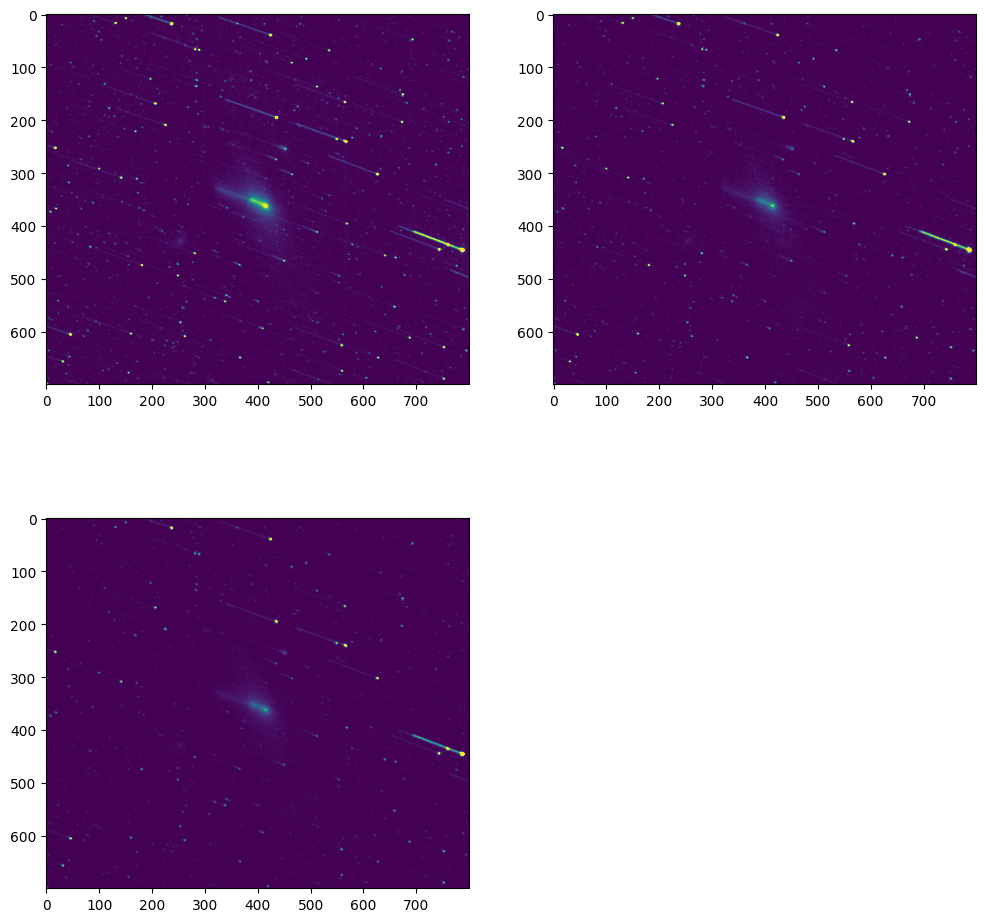

In [16]:
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(2, 2, 1)
plt.imshow(coadded_g[aslice], vmin=0, vmax=300)
ax1 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
plt.imshow(coadded_b[aslice], vmin=0, vmax=300)
ax2 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
plt.imshow(coadded_r[aslice], vmin=0, vmax=300)

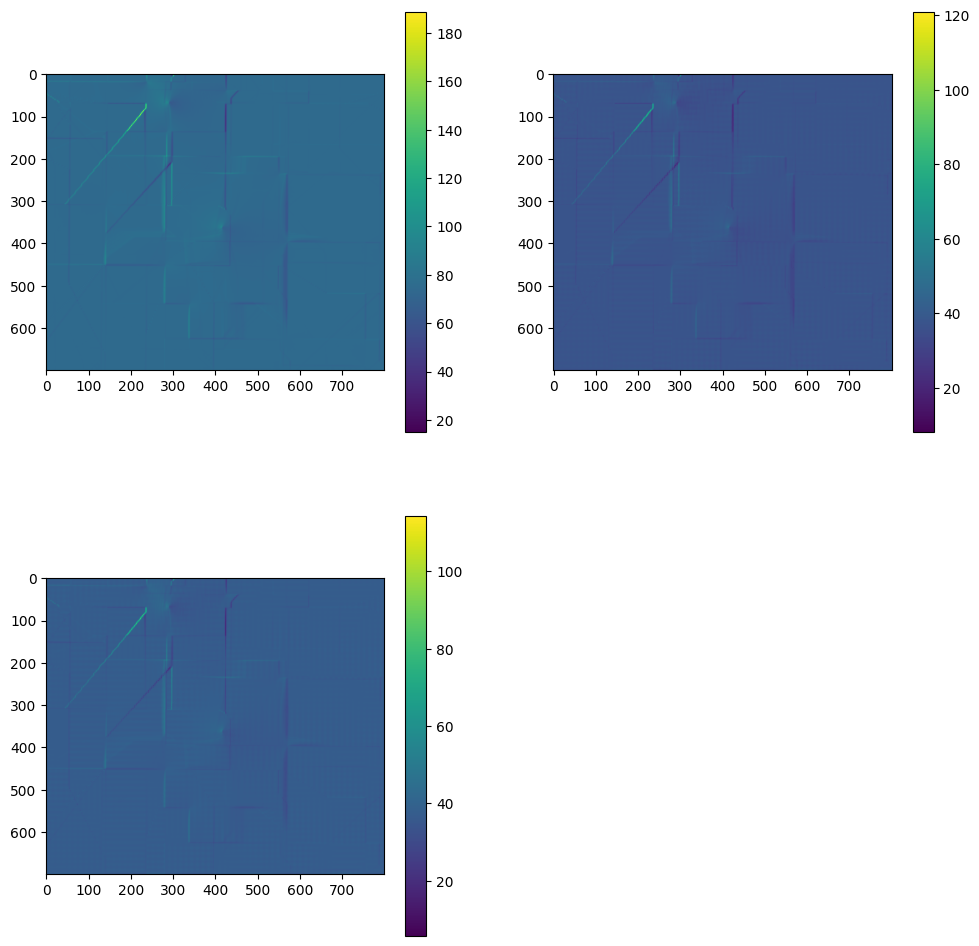

In [17]:
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(2, 2, 1)
plt.imshow(output_counts[1][aslice])
plt.colorbar()
ax1 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
plt.imshow(output_counts[2][aslice])
plt.colorbar()
ax2 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
plt.imshow(output_counts[0][aslice])
plt.colorbar()

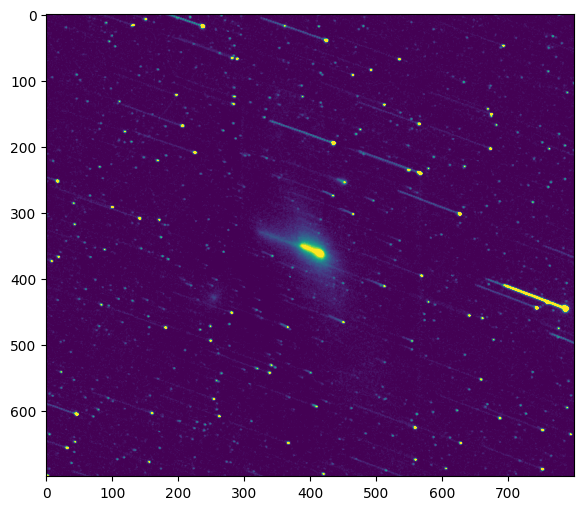

In [18]:
test_image = coadded_r * 1.93 + coadded_g + coadded_b * 1.90

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(test_image[aslice], vmin=0, vmax=600)

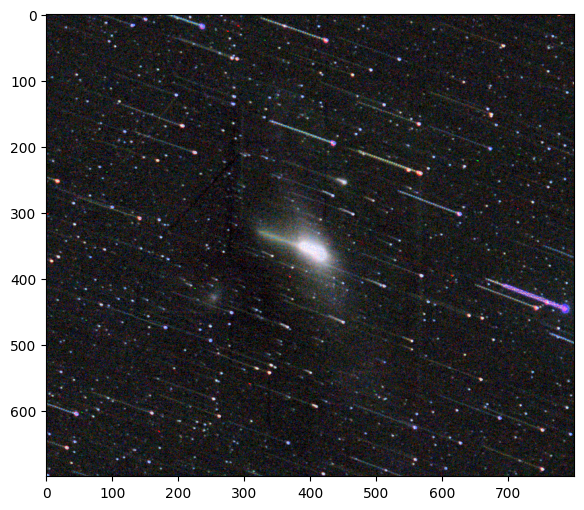

In [19]:
rgb_image = make_lupton_rgb(coadded_r * 2.4, coadded_g, coadded_b * 2., Q=2, stretch=100., minimum=-10.)

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb_image[aslice])

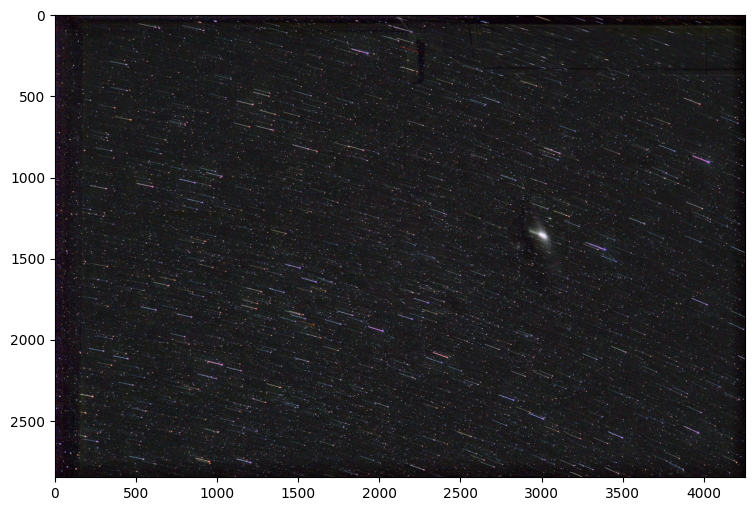

In [20]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb_image)

In [21]:
rgb_image.shape

(2848, 4256, 3)

In [22]:
plt.imsave("drizzle.tiff", rgb_image)